In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
from sklearn import metrics
from bayes_opt import BayesianOptimization
import shap

In [2]:
# Use the data with Frequency Count Frequency Encoding.
x_train = pd.read_csv("x_train_FE.csv")
y_train = pd.read_csv("y_train_FE.csv")
x_test = pd.read_csv("x_test_FE.csv")
y_test = pd.read_csv("y_test_FE.csv")

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (100000, 400)
y_train shape:  (100000, 1)
x_test shape:  (100000, 400)
y_test shape:  (100000, 1)


# LightGBM Model Tuning - Bayesian Optimization

In [3]:
# Define the fixed parameter we are not going to tune:
fix_params = {'application':'binary', 
          'boosting': 'gbdt',
          'learning_rate': 0.01,
          'metric':'auc', 
          'tree_learner': 'serial',
          'num_threads': 0,
          'bagging_freq': 0,
          'boost_from_average' : True}

In [4]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, max_depth, min_data_in_leaf, min_sum_hessian_in_leaf, bagging_fraction, feature_fraction,lambda_l1,lambda_l2):
        
        params = {'application':'binary', 
                  'boosting': 'gbdt',
                  'learning_rate': 0.01,
                  'metric':'auc', 
                  'tree_learner': 'serial',
                  'num_threads': 0,
                  'bagging_freq': 0,
                  'boost_from_average' : True
                  }
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
                
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =250, metrics=['auc'], early_stopping_rounds = 3500)
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 80),
                                            'max_depth': (3, 30),
                                            'min_data_in_leaf': (5, 80),
                                            'min_sum_hessian_in_leaf':(0.00001,100),
                                            'bagging_fraction': (0, 1),
                                            'feature_fraction': (1, 1),
                                            'lambda_l1': (0, 5.0),
                                            'lambda_l2': (0, 5.0),
                                            }, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params = bayes_parameter_opt_lgb(x_train , y_train, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=10000)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7898   |  0.9476   |  1.0      |  2.972    |  2.142    |  23.63    |  5.215    |  35.74    |  73.23    |
|  2        |  0.7542   |  0.4561   |  1.0      |  4.337    |  4.93     |  27.93    |  27.78    |  84.61    |  14.09    |
|  3        |  0.7811   |  0.7856   |  1.0      |  0.4801   |  4.717    |  25.3     |  43.87    |  87.35    |  48.38    |
|  4        |  0.7789   |  0.4501   |  1.0      |  2.097    |  3.202    |  19.43    |  12.91    |  96.6     |  61.9     |
|  5        |  0.7709   |  0.6796   |  1.0      |  0.1323   |  4.018    |  29.27    |  26.22    |  64.91    |  24.92    |
|  6        |  0.7367   |  0.9696   |  1.0      |  0.01634  |  4.91     |  3.764    |  77.6     |  2.445    |  75.61    |
|  7        |  0.7798   

In [5]:
opt_params

(0.7897930118165181,
 {'bagging_fraction': 0.9476322568516703,
  'feature_fraction': 1.0,
  'lambda_l1': 2.9721007219556626,
  'lambda_l2': 2.1415434246484737,
  'max_depth': 23.63179853695449,
  'min_data_in_leaf': 5.214544376070708,
  'min_sum_hessian_in_leaf': 35.74237455449936,
  'num_leaves': 73.22711642479314})

In [6]:
# The optimal parameter for LightGBM

# Define fix parameters:
opt_params[1]["application"] = fix_params["application"]
opt_params[1]["boosting"] = fix_params["boosting"]
opt_params[1]["learning_rate"] = fix_params["learning_rate"]
opt_params[1]["tree_learner"] = fix_params["tree_learner"]
opt_params[1]["num_threads"] = fix_params["num_threads"]
opt_params[1]["bagging_freq"] = fix_params["bagging_freq"]
opt_params[1]["boost_from_average"] = fix_params["boost_from_average"]
opt_params[1]["metric"] = fix_params["metric"]

# Define the optimal parameters from previous step that especially need to take care:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))


In [7]:
opt_params

(0.7897930118165181,
 {'application': 'binary',
  'bagging_fraction': 0.9476322568516703,
  'bagging_freq': 0,
  'boost_from_average': True,
  'boosting': 'gbdt',
  'feature_fraction': 1.0,
  'lambda_l1': 2.9721007219556626,
  'lambda_l2': 2.1415434246484737,
  'learning_rate': 0.01,
  'max_depth': 24,
  'metric': 'auc',
  'min_data_in_leaf': 5,
  'min_sum_hessian_in_leaf': 35.74237455449936,
  'num_leaves': 73,
  'num_threads': 0,
  'tree_learner': 'serial'})

In [8]:
# Build the final opt_params for the next step:
opt_params=opt_params[1]
opt_params

{'application': 'binary',
 'bagging_fraction': 0.9476322568516703,
 'bagging_freq': 0,
 'boost_from_average': True,
 'boosting': 'gbdt',
 'feature_fraction': 1.0,
 'lambda_l1': 2.9721007219556626,
 'lambda_l2': 2.1415434246484737,
 'learning_rate': 0.01,
 'max_depth': 24,
 'metric': 'auc',
 'min_data_in_leaf': 5,
 'min_sum_hessian_in_leaf': 35.74237455449936,
 'num_leaves': 73,
 'num_threads': 0,
 'tree_learner': 'serial'}

In [9]:
# Train LightGBM based on the parameters from the previous step.
features= [c for c in x_train.columns if c not in ['target','ID_code']]

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=31416)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx][features], label=y_train.iloc[val_idx])

    num_round = 1000000
    
    evaluation_results_lgbm = {}
    clf = lgb.train(opt_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 3500, evals_result=evaluation_results_lgbm)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))

Fold 0
Training until validation scores don't improve for 3500 rounds.
[500]	training's auc: 0.961574	valid_1's auc: 0.860591
[1000]	training's auc: 0.985989	valid_1's auc: 0.881154
[1500]	training's auc: 0.994583	valid_1's auc: 0.888372
[2000]	training's auc: 0.998059	valid_1's auc: 0.89179
[2500]	training's auc: 0.999387	valid_1's auc: 0.893334
[3000]	training's auc: 0.999815	valid_1's auc: 0.893835
[3500]	training's auc: 0.999933	valid_1's auc: 0.893861
[4000]	training's auc: 0.999971	valid_1's auc: 0.894064
[4500]	training's auc: 0.999987	valid_1's auc: 0.894302
[5000]	training's auc: 0.999996	valid_1's auc: 0.894467
[5500]	training's auc: 0.999999	valid_1's auc: 0.894563
[6000]	training's auc: 1	valid_1's auc: 0.89459
[6500]	training's auc: 1	valid_1's auc: 0.894646
[7000]	training's auc: 1	valid_1's auc: 0.894548
[7500]	training's auc: 1	valid_1's auc: 0.894462
[8000]	training's auc: 1	valid_1's auc: 0.894395
[8500]	training's auc: 1	valid_1's auc: 0.894346
[9000]	training's auc:

In [11]:
print("CV score: {:<8.5f}".format(roc_auc_score(y_test, predictions)))

CV score: 0.90042 


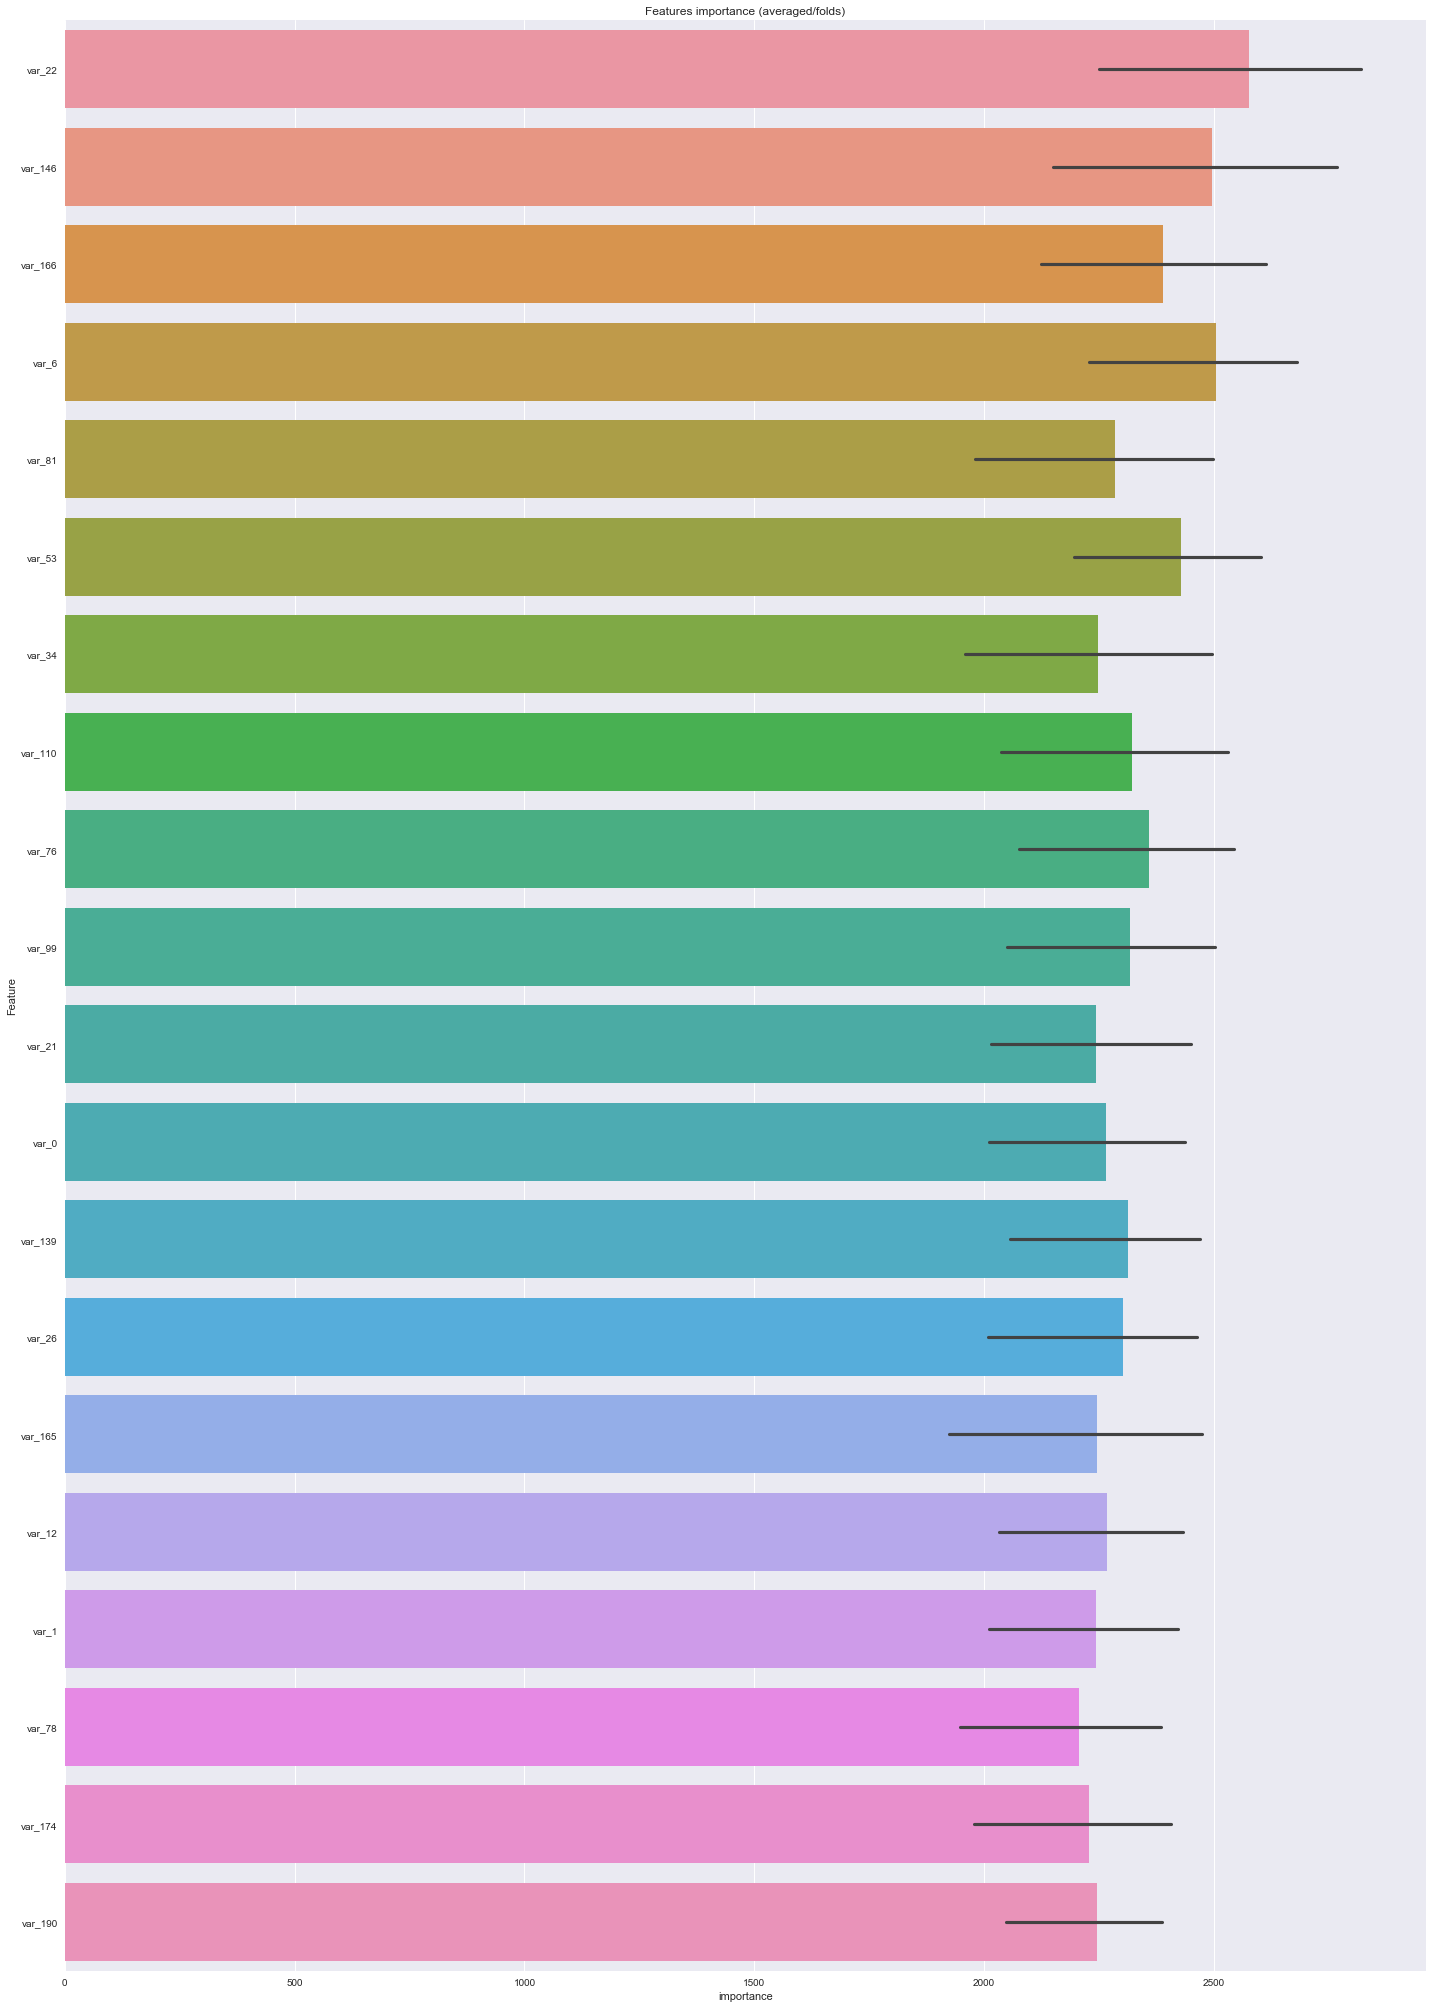

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(20,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('Feature_Importance.png')

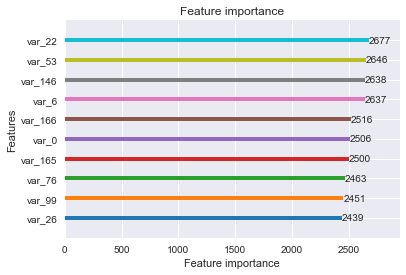

In [13]:
import matplotlib.colors as mcolors
ax = lgb.plot_importance(clf, max_num_features=10, color=mcolors.TABLEAU_COLORS)
plt.figure(figsize=(100,100))
plt.show()

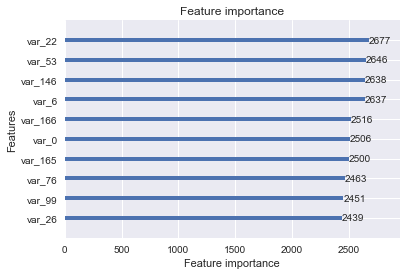

In [14]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/uc212037/Downloads/graphviz-2.38/release/bin'
## plot importance 
ax = lgb.plot_importance(clf, max_num_features=10)
plt.show()

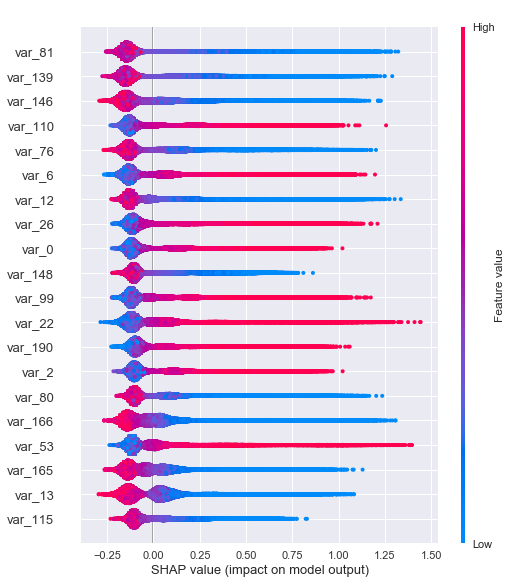

In [116]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

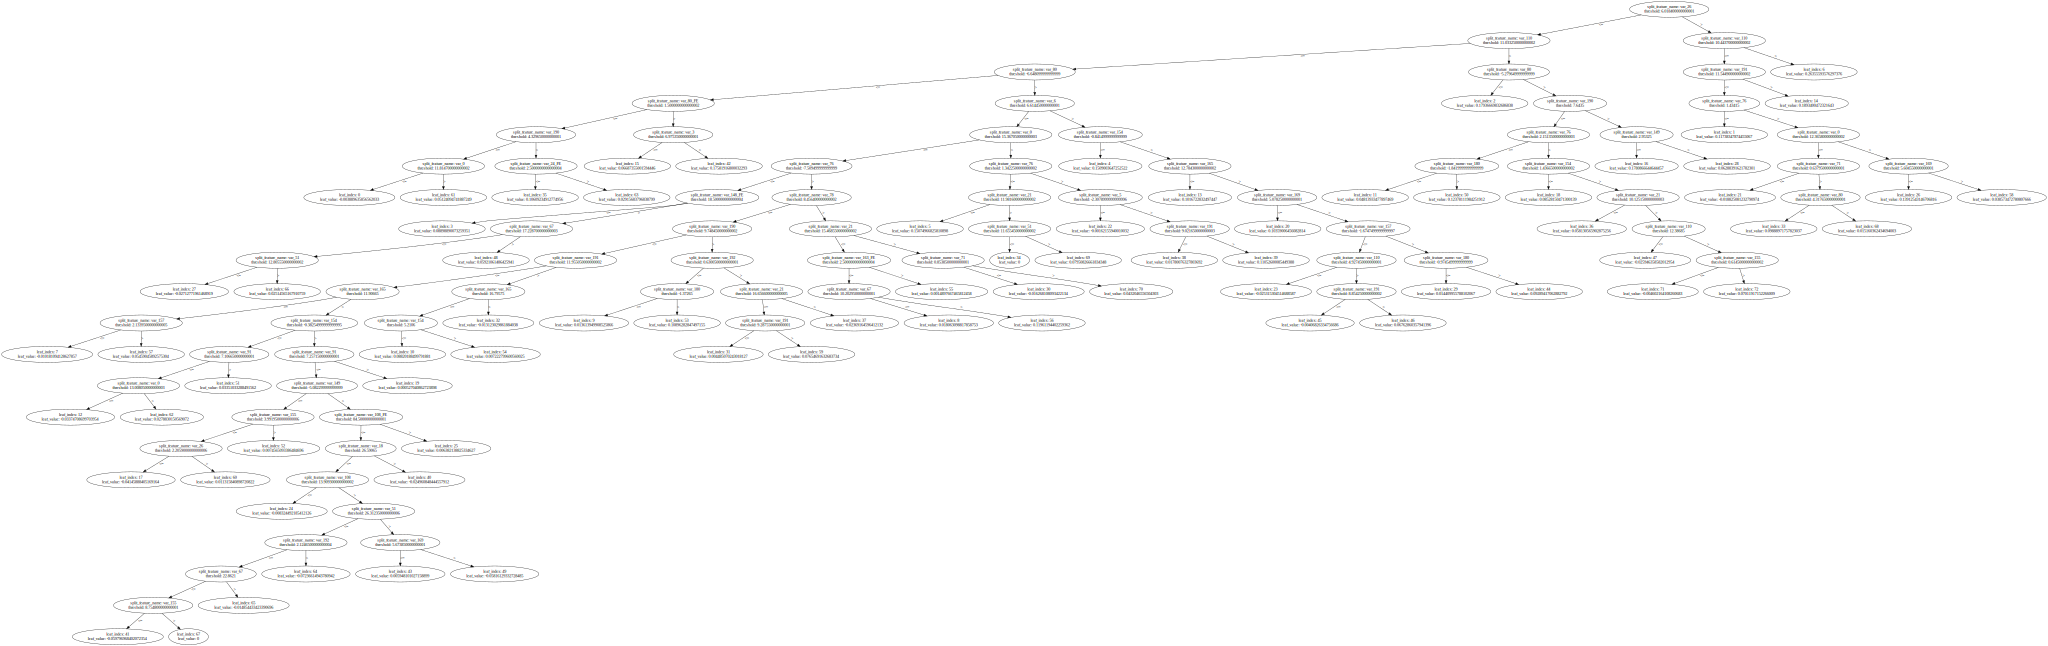

In [129]:
#tree visualization
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/uc212037/Downloads/graphviz-2.38/release/bin'

graph = lgb.create_tree_digraph(clf, tree_index=3, name='Tree1' )
graph.graph_attr.update(size="110,110")
graph

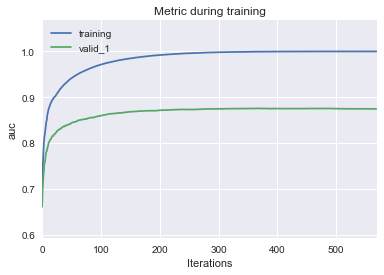

In [122]:
ax =lgb.plot_metric(evaluation_results_lgbm)
plt.show()

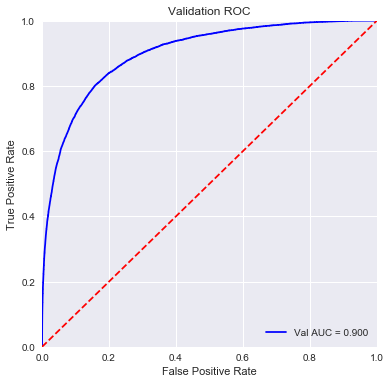

In [170]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])

plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [167]:
np.savetxt('lightGBM_predictions.txt', predictions)